# Expansion velocity of the universe

In 1929, Edwin Hubble published a [paper](http://www.pnas.org/content/pnas/15/3/168.full.pdf) in which he compared the radial velocity of objects with their distance. The former can be done pretty precisely with spectroscopy, the latter is much more uncertain. His original data are [here](table1.txt).

He saw that the velocity increases with distance and speculated that this could be the sign of a cosmological expansion. Let's find out what he did.

Load the data into an array with `numpy.genfromtxt`, make use of its arguments `names` and `dtype` to read in the column names from the header and choosing the data type on its own as needed. You should get 6 columns
   * `CAT`, `NUMBER`:  These two combined give you the name of the galaxy.
   * `R`: distance in Mpc
   * `V`: radial velocity in km/s
   * `RA`, `DEC`: equatorial coordinates of the galaxy
   
Make a scatter plot of V vs R. Don't forget labels and units...

In [1]:
import numpy as np
data = np.genfromtxt('table1.txt', names=True, dtype=None)
print("Samples:", len(data))
print("Data Types:", data.dtype)

Samples: 24
Data Types: [('CAT', 'S3'), ('NUMBER', 'S4'), ('R', '<f8'), ('V', '<i8'), ('RA', 'S8'), ('DEC', 'S9')]


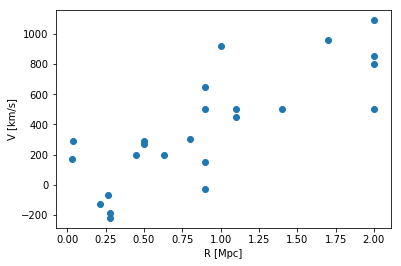

In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(data['R'], data['V'])
plt.xlabel('R [Mpc]')
plt.ylabel('V [km/s]')

Use `np.linalg.lstsq` to fit a linear regression function and determine the slope $H_0$ of the line $V=H_0 R$. For that, reshape $R$ as a $N\times1$ matrix (the design matrix) and solve for 1 unknown parameter. Add the best-fit line to the plot.

[ 423.93732323]


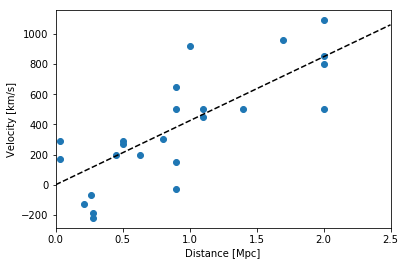

In [3]:
N = len(data)
X = data['R'].reshape((N,1))
params, _, _, _ = np.linalg.lstsq(X, data['V'])
print(params)
H0 = params[0]

R = np.linspace(0,2.5,100)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data['R'], data['V'])
ax.plot(R, H0*R, 'k--')
ax.set_xlim(xmin=0, xmax=2.5)
ax.set_xlabel('Distance [Mpc]')
ax.set_ylabel('Velocity [km/s]')

Why is there scatter with respect to the best-fit curve? Is it fair to only fit for the slope and not also for the intercept? How would $H_0$ change if you include an intercept in the fit?

[ -40.7836491   454.15844092]


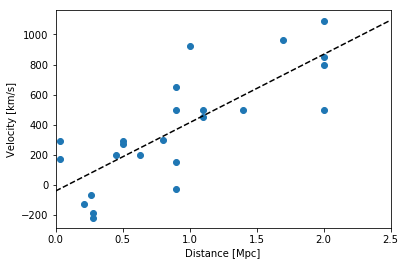

In [4]:
X = np.ones((N, 2))
X[:,1] = data['R']
params, _, _, _ = np.linalg.lstsq(X, data['V'])
print(params)
inter, H0 = params

R = np.linspace(0,2.5,100)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data['R'], data['V'])
ax.plot(R, H0*R + inter, 'k--')
ax.set_xlim(xmin=0, xmax=2.5)
ax.set_xlabel('Distance [Mpc]')
ax.set_ylabel('Velocity [km/s]')

## Correcting for motion of the sun

$V$ as given in the table is a combination of any assumed cosmic expansion and the motion of the sun with respect to that cosmic frame. So, we need to generalize the model to $V=H_0 R + V_s$, where the solar velocity is given by $V_s = X \cos(RA)\cos(DEC) + Y\sin(RA)\cos(DEC)+Z\sin(DEC)$. We'll use `astropy` to read in the RA/DEC coordinate strings and properly convert them to degrees (and then radians):

In [5]:
import astropy.coordinates as coord
import astropy.units as u

pos = coord.SkyCoord(ra=data['RA'].astype('U8'), dec=data['DEC'].astype('U9'), unit=(u.hourangle,u.deg),frame='fk5')
ra_ = pos.ra.to(u.deg).value * np.pi/180
dec_ = pos.dec.to(u.deg).value * np.pi/180

Construct a new $N\times4$ design matrix for the four unknown parameters $H_0$, $X$, $Y$, $Z$ to account for the solar motion. The resulting $H_0$ is Hubble's own version of the "Hubble constant". What do you get?

In [6]:
Ah = np.empty((N,4))
Ah[:,0] = data['R']
Ah[:,1] = np.cos(ra_)*np.cos(dec_)
Ah[:,2] = np.sin(ra_)*np.cos(dec_)
Ah[:,3] = np.sin(dec_)
params_h, _, _, _ = np.linalg.lstsq(Ah, data['V'])
print(params_h)
H0 = params_h[0]

[ 465.17797833  -67.84096674  236.14706994 -199.58892695]


Make a scatter plot of $V-V_S$ vs $R$. How is it different from the previous one without the correction for solar velicity. Add the best-fit linear regression line.

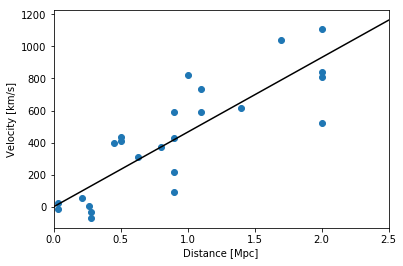

In [7]:
VS = params_h[1]*Ah[:,1] + params_h[2]*Ah[:,2] + params_h[3]*Ah[:,3]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data['R'], data['V'] - VS)
ax.plot(R, H0*R, 'k-')
ax.set_xlim(xmin=0, xmax=2.5)
ax.set_xlabel('Distance [Mpc]')
ax.set_ylabel('Velocity [km/s]')

Using `astropy.units`, can you estimate the age of the universe from $H_0$? Does it make sense?

In [8]:
H0q = H0 * u.km / u.s / u.Mpc
(1./H0q).to(u.Gyr)

<Quantity 2.101974442513894 Gyr>

## Deconstructing lstsq

So far we have not incorporated any measurement uncertainties. Can you guess or estimate them from the scatter with respect to the best-fit line? You may want to look at the residuals returned by `np.linalg.lstsq`...

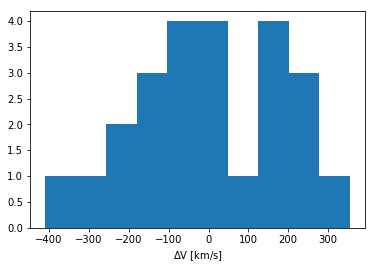

In [9]:
scatter = data['V'] - VS - H0*data['R']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(scatter, 10)
ax.set_xlabel('$\Delta$V [km/s]')

Let see how adopting a suitable value $\sigma$ for those uncertainties would affect the estimate of $H_0$?

The problem you solved so far is $Ax=b$, and errors don't occur. With errors the respective equation is changed to $A^\top \Sigma^{-1} Ax=A^\top \Sigma^{-1}b$, where in this case the covariance matrix $\Sigma=\sigma^2\mathbf{1}$. This problem can still be solved by `np.linalg.lstsq`.

Construct the modified design matrix and data vector and get a new estimate of $H_0$. Has it changed? Use `np.dot`, `np.transpose`, and `np.linalg.inv` (or their shorthands).

In [10]:
error = scatter.std()
Sigma = error**2*np.eye(N)
Ae = np.dot(Ah.T, np.dot(np.linalg.inv(Sigma), Ah))
be = np.dot(Ah.T, np.dot(np.linalg.inv(Sigma), data['V']))
params_e, _, _, _ = np.linalg.lstsq(Ae, be)
print(params_e)

[ 465.17797833  -67.84096674  236.14706994 -199.58892695]


Compute the parameter covariance matrix $S=(A^\top \Sigma^{-1} A)^{-1}$ and read off the variance of $H_0$. Update your plot to illustrate that uncertainty.

In [11]:
S = np.linalg.inv(Ae)
dH0 = np.sqrt(S[0,0])
print(dH0)

50.7640654387


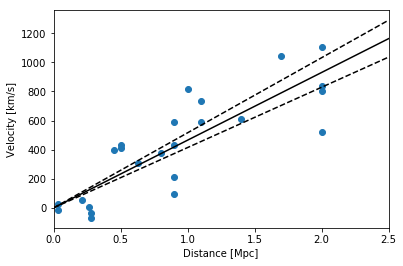

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data['R'], data['V'] - VS)
ax.plot(R, H0*R, 'k-')
ax.plot(R, (H0-dH0)*R, 'k--')
ax.plot(R, (H0+dH0)*R, 'k--')
ax.set_xlim(xmin=0, xmax=2.5)
ax.set_xlabel('Distance [Mpc]')
ax.set_ylabel('Velocity [km/s]')

How large is the relative error?  Would that help with the problematic age estimate above?

In [13]:
H0q = (H0-dH0) * u.km / u.s / u.Mpc
(1./H0q).to(u.Gyr)

<Quantity 2.359457999003244 Gyr>

Compare the noise-free result from above (Hubble's result) with $SA^\top \Sigma^{-1}b$. Did adopting errors change the result?

In [14]:
params_h, _, _, _ = np.linalg.lstsq(Ah, data['V'])
print(params_h)
print (np.dot(S, be))

[ 465.17797833  -67.84096674  236.14706994 -199.58892695]
[ 465.17797833  -67.84096674  236.14706994 -199.58892695]
